In [ ]:
import functools
import itertools
import logging
import math
import os
import pickle
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import yaml

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 12.0)})
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
import torch.nn.functional as F

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [ ]:
from lda4rec.datasets import Interactions, DataLoader, random_train_test_split
from lda4rec.evaluations import summary
from lda4rec.estimators import MFEst, PopEst, LDA4RecEst, SNMFEst
from lda4rec.utils import process_ids, cmp_ranks
from lda4rec import lda

In [ ]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.distributions import constraints
from pyro.infer import SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, config_enumerate

## ToDos:

* Allow training on new cold-start users, i.e. fix the parameters after a training on items. Split Data into Warm-Train, Cold-Train and Cold-Test. Flow:
  1. Train on Warm-Training Dataset like usual (all parameters are learned)
  2. Train on Cold-Train having selected users (item parameters are fixed but user params are still learned)
  3. Test on Cold-Test for those users.
  
  This is the protocol as described in https://www.ijcai.org/Proceedings/15/Papers/559.pdf. First implement in the estimators the logic for doing the trainings, then the evaluation protocol. This needs to be done for classical MF and LDA4Rec.
* Build the hierarchical model in `models.py` that should be more efficient than MF and even LDA4Rec.
* Check if $\lambda_u$ shouldn't be rather beta distributed

In [ ]:
import neptune.new as neptune
# init dummy neptune to avoid problems with logging
neptune.init(mode='offline') 

In [ ]:
from icecream import ic, install

install()
# configure icecream
def ic_str(obj):
    if hasattr(obj, "shape"):
        return f"{obj} "  #
    else:
        return str(obj)

In [ ]:
ic.configureOutput(argToStringFunction=ic_str)

## Experimenting with different estimators

In [ ]:
loader = DataLoader()
data = loader.load_movielens("100k")

In [ ]:
max_interactions = 200
data.max_user_interactions_(max_interactions, rng=42)

In [9]:
data.implicit_(0.)
train, test = random_train_test_split(data, rng=42)

In [10]:
pop_est = PopEst()
pop_est.fit(train)

In [11]:
summary(pop_est, train=train, test=test)

,train,test
metric,,
prec,0.289836,0.101149
recall,0.054435,0.069478
mrr,0.515369,0.291043
map,0.179127,0.060088


In [12]:
mf_est = MFEst(embedding_dim=4, n_iter=30)
mf_est.fit(train)

INFO:lda4rec.estimators:Epoch     0: loss 0.40562560622756544
INFO:lda4rec.estimators:Epoch     1: loss 0.21598115784896388
INFO:lda4rec.estimators:Epoch     2: loss 0.14306467552040075
INFO:lda4rec.estimators:Epoch     3: loss 0.11989548758075044
INFO:lda4rec.estimators:Epoch     4: loss 0.10712877641859893
INFO:lda4rec.estimators:Epoch     5: loss 0.09992506683275507
INFO:lda4rec.estimators:Epoch     6: loss 0.09250755140910277
INFO:lda4rec.estimators:Epoch     7: loss 0.08738417982853748
INFO:lda4rec.estimators:Epoch     8: loss 0.08605034694679685
INFO:lda4rec.estimators:Epoch     9: loss 0.08338154063534897
INFO:lda4rec.estimators:Epoch    10: loss 0.080704571321808
INFO:lda4rec.estimators:Epoch    11: loss 0.07779883754414481
INFO:lda4rec.estimators:Epoch    12: loss 0.07622901721278558
INFO:lda4rec.estimators:Epoch    13: loss 0.07512939585926565
INFO:lda4rec.estimators:Epoch    14: loss 0.07394725554496856
INFO:lda4rec.estimators:Epoch    15: loss 0.07271714290050237
INFO:lda4r

0.06428103890471362

In [13]:
summary(mf_est, train=train, test=test)

,train,test
metric,,
prec,0.324918,0.120361
recall,0.062223,0.087146
mrr,0.028884,0.039773


In [23]:
lda_est = LDA4RecEst(embedding_dim=2, n_iter=10_000, batch_size=128, learning_rate=0.001, use_jit=True)

In [24]:
model_state = "../models/lda_est2.state"
if Path(model_state).is_file():
    lda_est.load(model_state, train)
else:
    lda_est.fit(train)
    lda_est.save(model_state)

INFO:lda4rec.estimators:Epoch     0: loss 506132.15625


In [16]:
# Path(model_state).unlink()

In [25]:
summary(lda_est, train=train, test=test)

,train,test
metric,,
prec,0.003770,0.001806
recall,0.000403,0.000618
mrr,0.005431,0.002935
map,0.000576,0.000293


In [17]:
summary(lda_est, train=train, test=test)

,train,test
metric,,
prec,0.335082,0.140394
recall,0.064961,0.108763
mrr,0.030984,0.049385


In [33]:
hlda_est = LDA4RecEst(embedding_dim=2, n_iter=100, batch_size=128, learning_rate=0.001, use_jit=True, model=lda.hier_model, guide=lda.hier_guide)

In [34]:
model_state = "../models/hlda4_est.state"
if Path(model_state).is_file():
    hlda_est.load(model_state, train)
else:
    hlda_est.fit(train)
    hlda_est.save(model_state)

INFO:lda4rec.estimators:Epoch     0: loss 346116.78125


In [35]:
summary(hlda_est, train=train, test=test)

,train,test
metric,,
prec,0.346721,0.144335
recall,0.068070,0.108877
mrr,0.555537,0.325935
map,0.229932,0.093002


In [11]:
summary(pop_est, train=train, test=test)

,train,test
metric,,
prec,0.289836,0.100821
recall,0.054435,0.069178
mrr,0.025945,0.036412


In [61]:
import rankereval

In [81]:
from rankereval import BinaryLabels, Rankings

In [116]:
scores = calc_preds(hlda_est, test, train)

In [117]:
scores.shape

(610, 9724)

In [122]:
test.to_coo().shape

(610, 9724)

In [101]:
Rankings.from_scores(scores[:5])

In [75]:
scores[0]

array([ 34,  16,  15, ..., 102, 131, 204])

In [19]:
summary_ng(pop_est, train=train, test=test)

,train,test
metric,,
prec,0.289836,0.101149
recall,0.054435,0.069478
mrr,0.515369,0.291043
map,0.179127,0.060088


<AxesSubplot:ylabel='Count'>

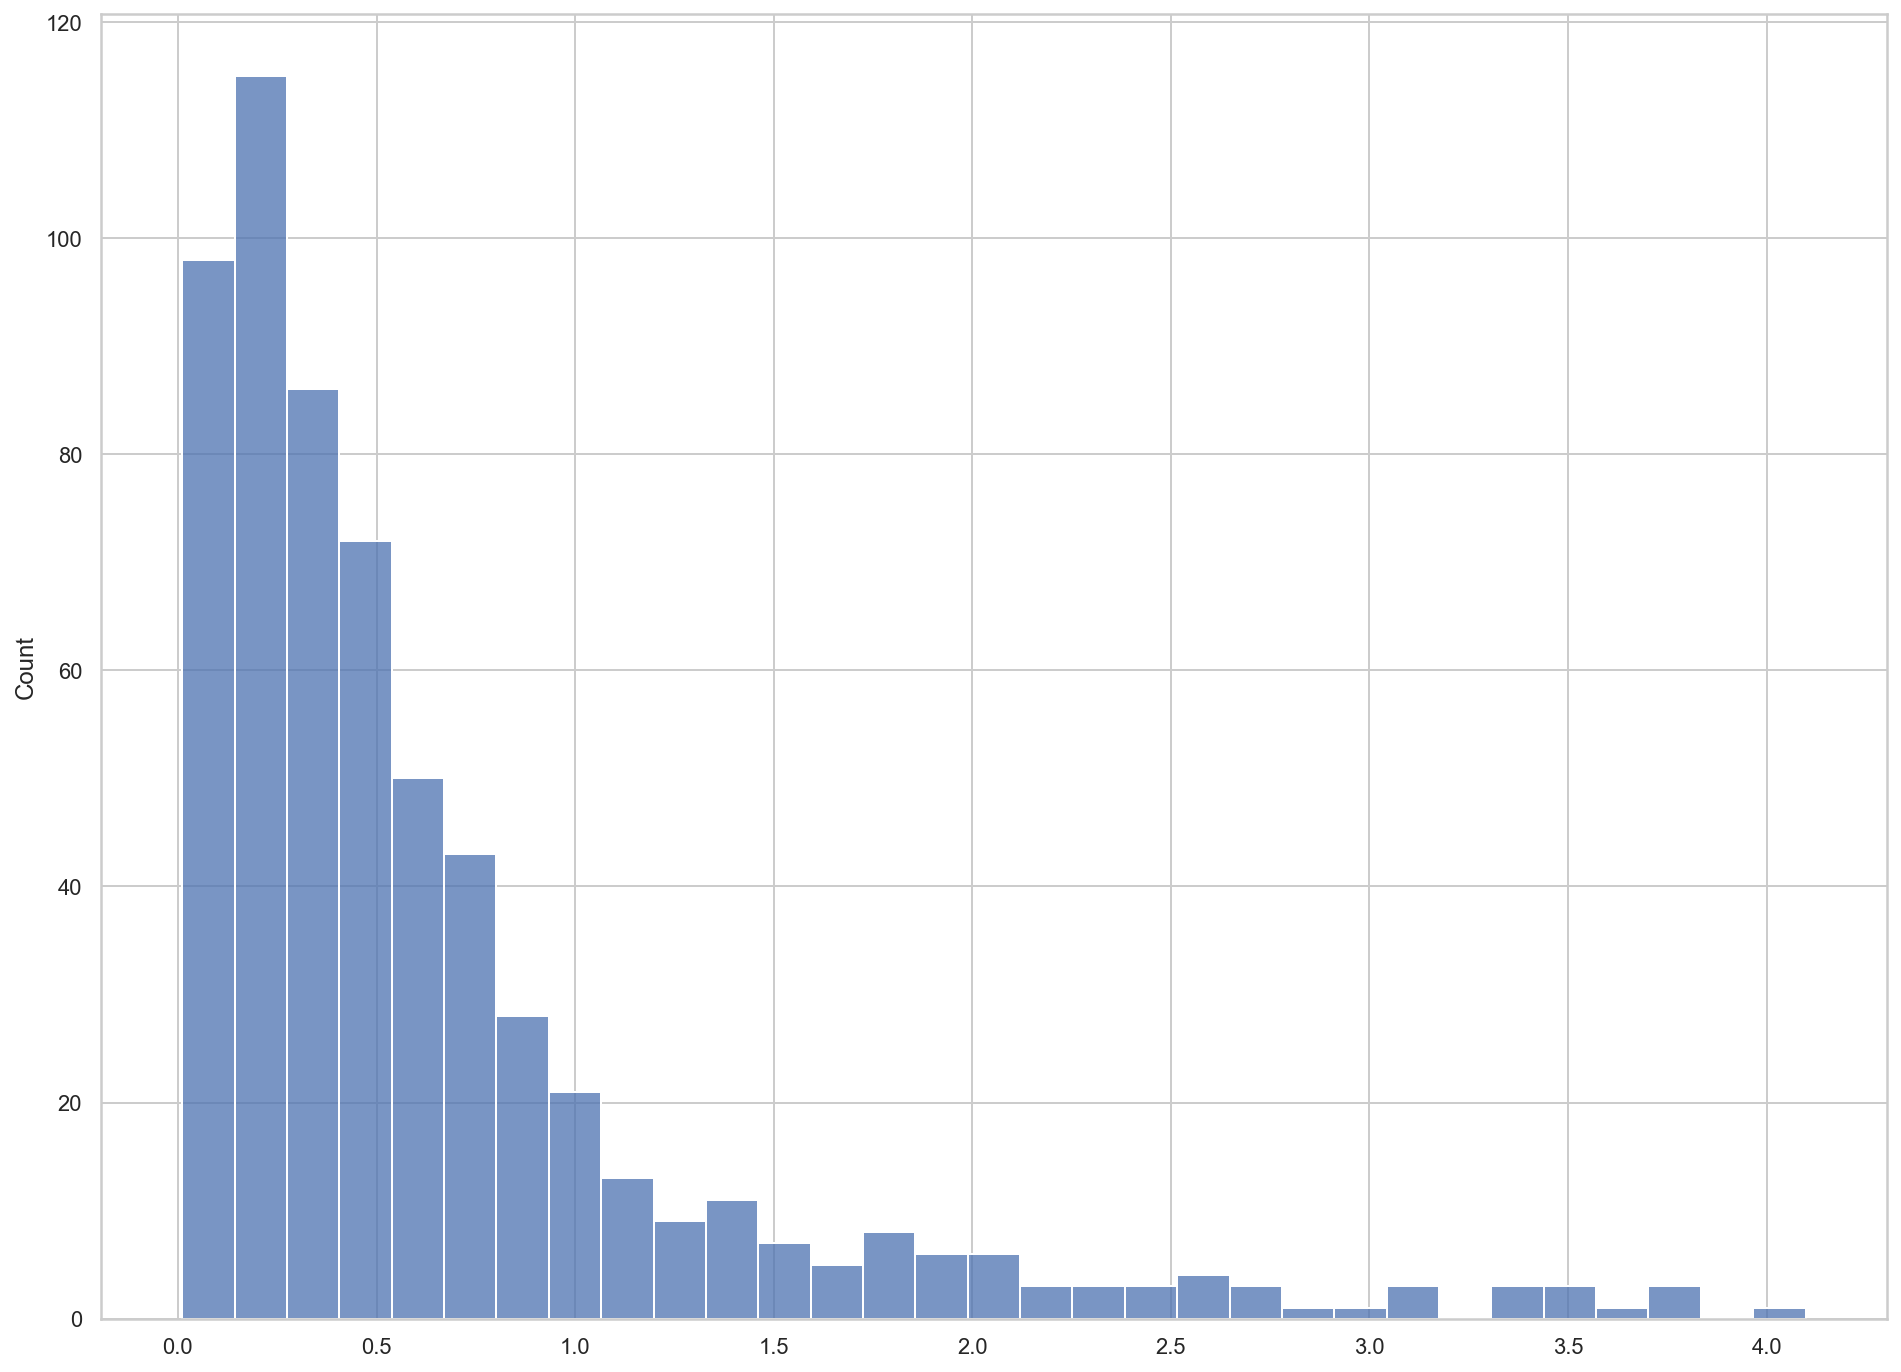

In [50]:
sns.histplot(torch.exp(hlda_est.user_pop_devs))

In [51]:
torch.mean(dist.HalfNormal(scale=3).sample((10_000,)))

tensor(2.3783)

In [58]:
pyro.get_param_store()['user_pop_devs_prior_sigma_scale']

tensor([0.0296], grad_fn=<AddBackward0>)

<AxesSubplot:ylabel='Count'>

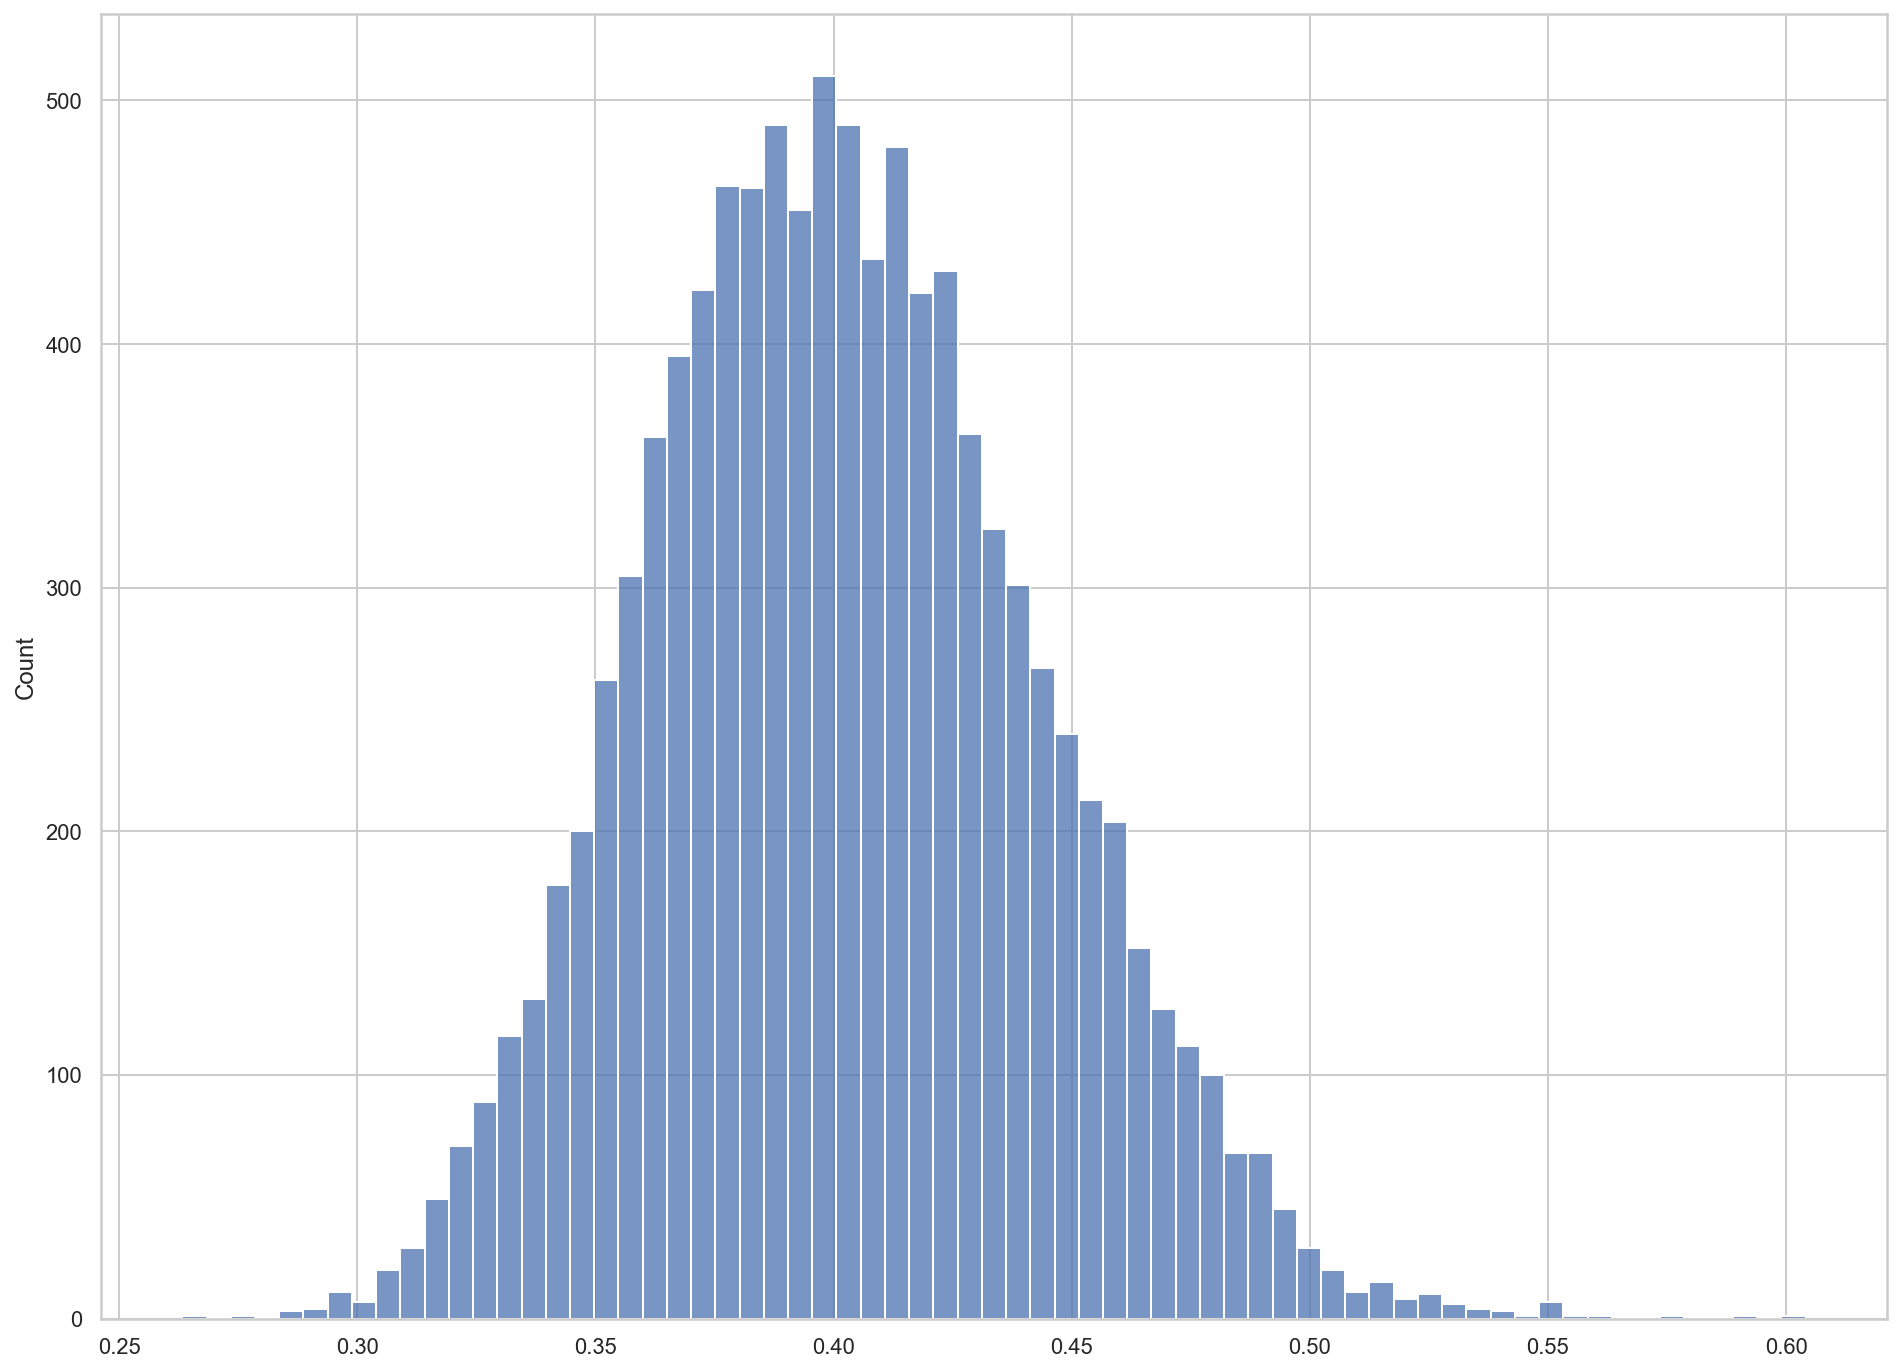

In [56]:
sns.histplot(dist.LogNormal(-0.916, 0.1).sample((10_000,)))

In [20]:
summary(hlda_est, train=train, test=test)

,train,test
metric,,
prec,0.358197,0.151067
recall,0.069778,0.113728
mrr,0.032355,0.048623


In [ ]:
lda_est.predict_posterior = True
summary(lda_est, train=train, test=test)

<AxesSubplot:ylabel='Count'>

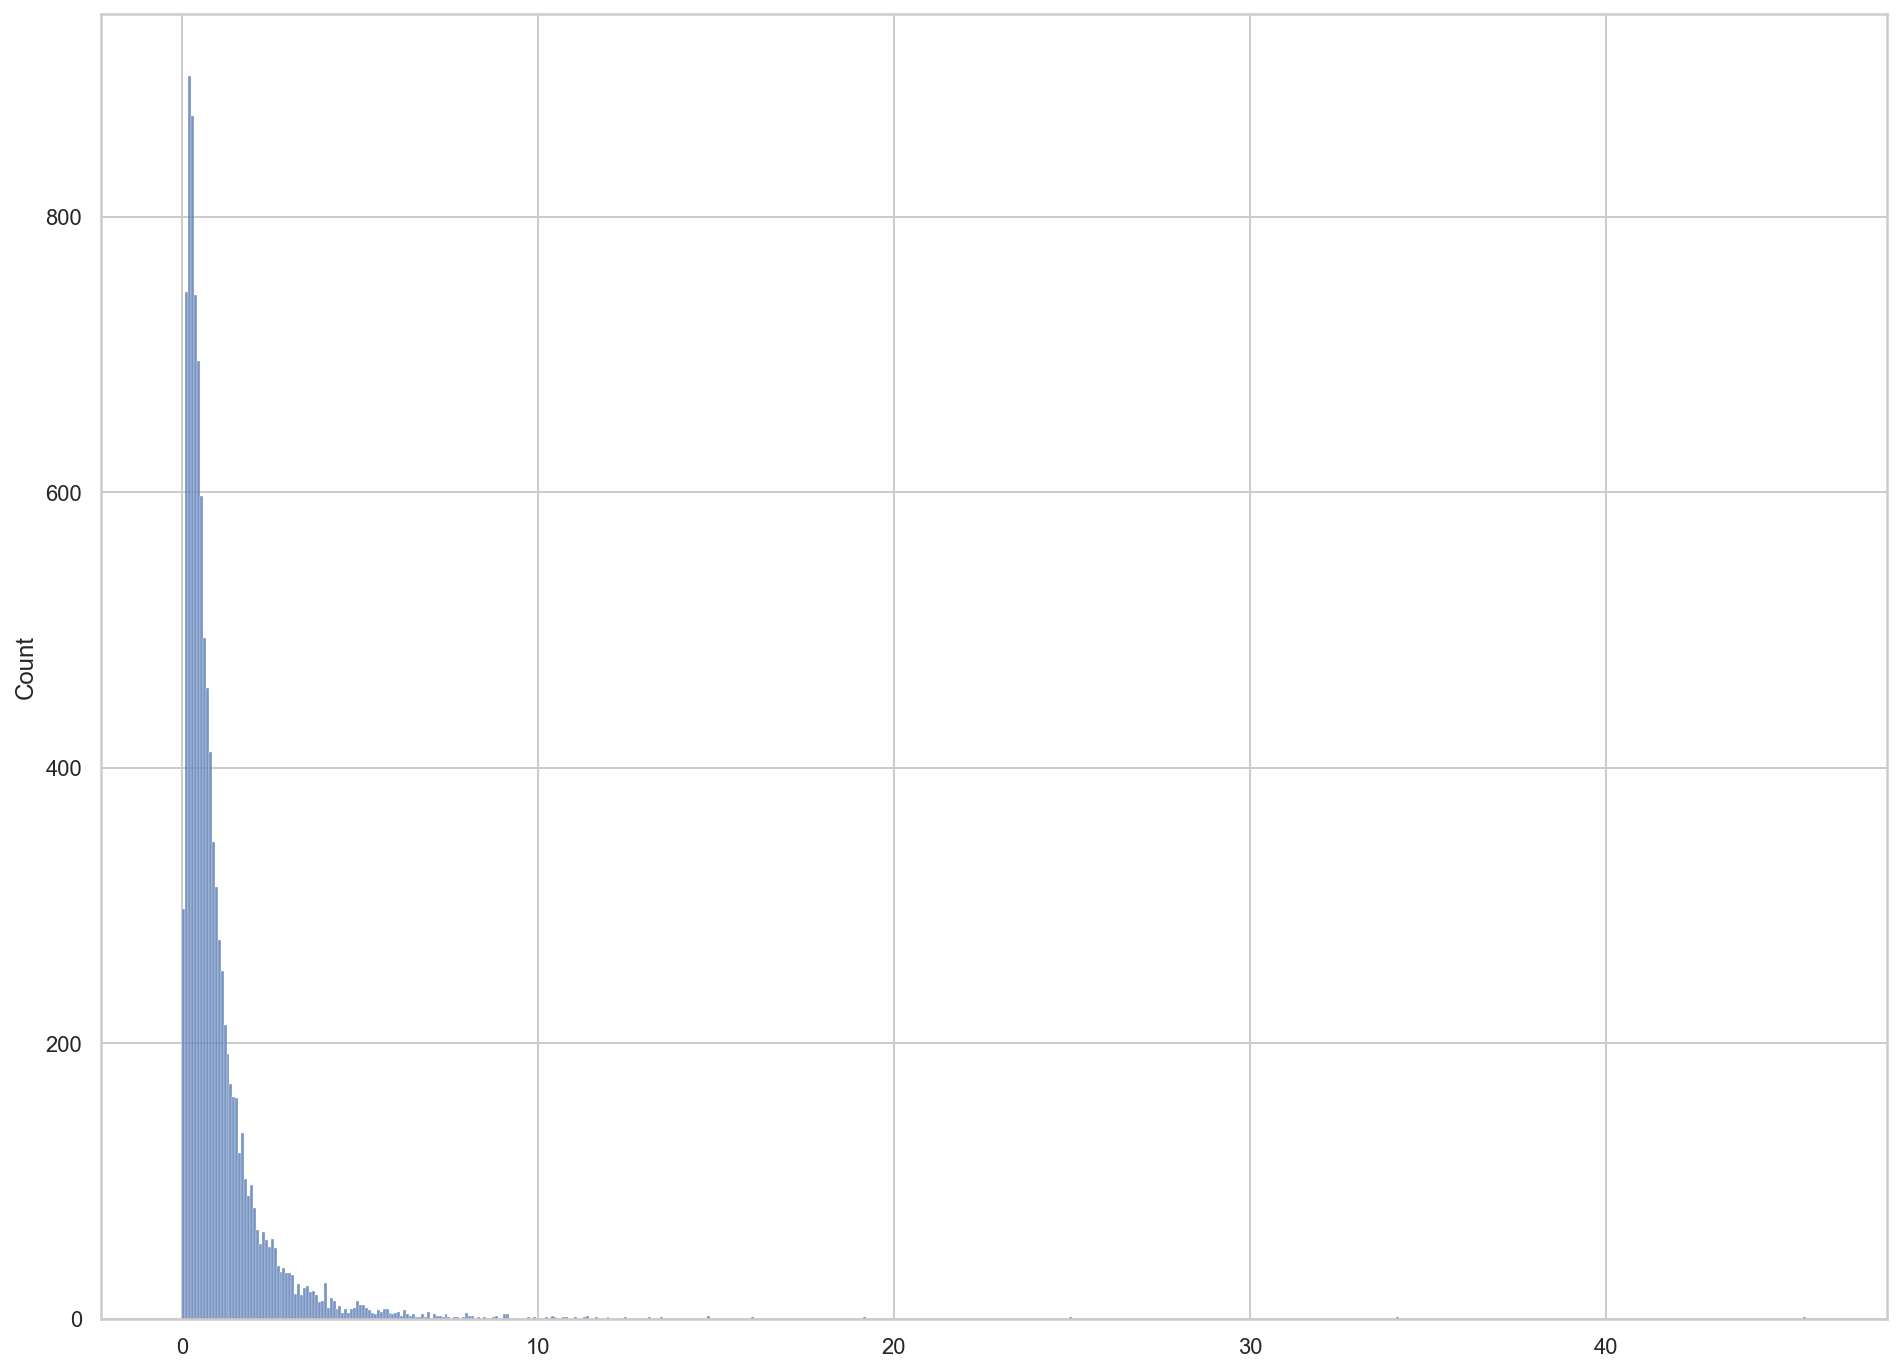

In [46]:
sns.histplot(dist.LogNormal(-0.5, 1.).sample((10_000,)))

In [ ]:
sns.histplot(dist.LogNormal(-0.5,10).sample((10_000,)))
plt.xlim(0, 5)

In [55]:
np.exp(-0.5)

0.6065306597126334

In [24]:
torch.rand(torch.bincount(torch.arange(10)).shape)

tensor([0.1223, 0.3370, 0.8262, 0.8811, 0.8574, 0.0309, 0.0379, 0.9681, 0.5868,
        0.8301])

In [42]:
lda_est.user_pop_devs.shape

NameError: name 'lda_est' is not defined

In [52]:
lda_est.user_pop_devs.shape

torch.Size([610])

## Matrix Factorization as aLDA formulation

In [706]:
user_id = 128
orig_scores = mf_est.predict(np.array([user_id], dtype=np.int))
item_probs = mf_est.get_item_probs(user_id)

In [707]:
cmp_ranks(orig_scores, item_probs, eps=1e-5)

True

In [708]:
torch.where

<function _VariableFunctionsClass.where>

In [709]:
np.sum(np.argsort(orig_scores) != np.argsort(item_probs))

8

In [710]:
torch.min(torch.eye(10), dim=0)

torch.return_types.min(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
indices=tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [711]:
torch.zeros(1).shape

torch.Size([1])

In [712]:
torch.min(torch.arange(10)-1.).shape

torch.Size([])

In [713]:
torch.zeros(0)

tensor([])

In [60]:
n_samples = 200
rng = np.random.default_rng(42)
model_params["interactions"] = data.interactions

predictive = Predictive(model, guide=guide, num_samples=n_samples)
samples = {
    k: v.detach().cpu().numpy()
    for k, v in predictive(**model_params).items()
}

IndexError: index 1 is out of bounds for dimension 0 with size 1